In [135]:
import pandas as pd
import re
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Normalization, Dense, Dropout, Normalization
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping

# Index
* [Encoding the Target](#Encoding-the-Target)
* [Split](#Split)
* [Train the Model](#Train-the-Model)
* [Testing](#Testing)
* [Saving the Model](#Saving-the-Model)

# Encoding the Target

[Index](#Index)

[`regression`](https://www.tensorflow.org/tutorials/keras/regression)
[`layers/Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization)

In [136]:
dataframe=pd.read_csv('/tf/ML-project/data/processedDataframe.csv')

In [137]:
# Ejemplo con LabelEncoder
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(dataframe["Category"])

In [138]:
dataframe.drop(columns=["Category"]).head(2)

,Nutrient Data Bank Number,Data.Alpha Carotene,Data.Ash,Data.Beta Carotene,Data.Beta Cryptoxanthin,Data.Carbohydrate,Data.Cholesterol,Data.Choline,Data.Fiber,Data.Kilocalories,...,Data.Major Minerals.Potassium,Data.Major Minerals.Sodium,Data.Major Minerals.Zinc,Data.Vitamins.Vitamin A - IU,Data.Vitamins.Vitamin A - RAE,Data.Vitamins.Vitamin B12,Data.Vitamins.Vitamin B6,Data.Vitamins.Vitamin C,Data.Vitamins.Vitamin E,Data.Vitamins.Vitamin K
0,1001,0,2.11,158,0,0.06,215,19,0.0,717,...,24,576,0.09,2499,684,0.17,0.003,0.0,2.32,7.0
1,1002,0,2.11,158,0,0.06,219,19,0.0,717,...,26,827,0.05,2499,684,0.13,0.003,0.0,2.32,7.0


# Split
[Index](#Index)

In [139]:
X, y = dataframe.drop(columns=["Category"]), y_encoded

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Train the Model
[Index](#Index)

In [140]:
n_classes
n_features

41

In [141]:
# Número de características de entrada y clases de salida
n_features = len(X.columns)
n_classes = pd.Series(y_encoded).nunique()

# Crear el modelo
model = Sequential([
    Normalization(input_shape=(n_features,)),  # Capa de normalización
    Dense(128, activation='relu'),  # Primera capa oculta
    Dense(256, activation='relu'),  # Segunda capa oculta con regularización L1_L2
    Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),  # Segunda capa oculta con regularización L1_L2
    Dropout(0.2),  # Capa de Dropout
    Dense(128, activation='relu'),  # Tercera capa oculta
    Dense(n_classes, activation='softmax')  # Capa de salida
])

# Antes de compilar el modelo, debes adaptar la capa de Normalization a tus datos
# Esto calculará la media y la desviación estándar de tus datos de entrenamiento
# y los usará para la normalización durante el entrenamiento e inferencia.

# Supongamos que 'X_train' son tus datos de entrenamiento
model.layers[0].adapt(X_train.to_numpy())

# Compilar el modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Resumen del modelo
model.summary()

# Entrenar el modelo como antes
# model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_14                │ (None, 41)             │            83 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 128)            │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 669)            │        86,301 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 223,472 (872.94 KB)

 Trainable params: 223,389 (872.61 KB)

 Non-trainable params: 83 (336.00 B)

In [142]:
# Entrenar el modelo

early_stopper = EarlyStopping(
    monitor='val_loss',  # Monitoriza la pérdida de validación
    patience=5,          # Número de épocas sin mejora después de las cuales se detendrá el entrenamiento
    verbose=1,           # Muestra mensajes cuando se detiene el entrenamiento
    mode='min',          # Detiene el entrenamiento cuando la cantidad monitoreada ha dejado de disminuir
    restore_best_weights=True  # Restaura los pesos del modelo desde la época con el mejor valor de la cantidad monitoreada
)

history = model.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopper]
)  # Usa el 20% de los datos para validación

Epoch 1/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.0937 - loss: 20.6803 - val_accuracy: 0.1358 - val_loss: 5.0105
Epoch 2/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1524 - loss: 4.6399 - val_accuracy: 0.1559 - val_loss: 4.7232
Epoch 3/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1745 - loss: 4.3150 - val_accuracy: 0.1942 - val_loss: 4.5577
Epoch 4/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2078 - loss: 4.0427 - val_accuracy: 0.2374 - val_loss: 4.4060
Epoch 5/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2546 - loss: 3.8316 - val_accuracy: 0.2716 - val_loss: 4.1995
Epoch 6/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2759 - loss: 3.5993 - val_accuracy: 0.2807 - val_loss: 4.1833
Epoch 7/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3093 - loss: 3.3564 - val_accuracy: 0.3320 - val_loss: 4.0306
Epoch 8/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3240 - loss: 3.2479 - val_accuracy:

# Testing
[Index](#Index)

In [143]:
# Evaluar el modelo con el conjunto de datos de prueba
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3636 - loss: 3.9171
Test Loss: 3.8139007091522217
Test Accuracy: 0.37310993671417236


# Saving the Model

In [144]:
model.save('../models/categoryModel.keras')

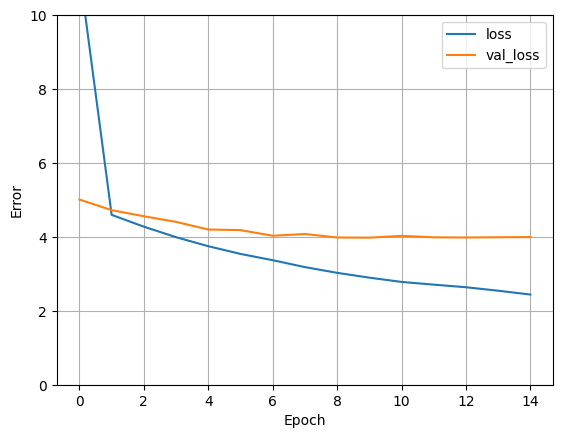

In [145]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)